# Statistical foundations of Machine Learning

## INFO-F-422 House Prices project

Madalina Ciortan

May 11, 2017

## Overview

The current project aims at solving the House Prices Kaggle competition :https://www.kaggle.com/c/house-prices-advanced-regression-techniques
In order to predict the house Sale Price, this report implements the following steps:
- data visualisation, exploration and selection
- imputation
- feature selection
- model selection
- ensemble techniques
- prediction
- conclusion

In [118]:
library(dummies)
library(ggplot2)
require(corrplot) # correlation plot
library(rpart)
library(e1071)
library(lazy)
library(nnet)
library(tree)

Warning message:
"package 'tree' was built under R version 3.3.3"

## Data overview and preprocessing

Load data sets:

In [1]:
print(2)

[1] 2


In [17]:
input <- read.csv("./input/train.csv", stringsAsFactors = FALSE)
output <- read.csv("./input/test.csv", stringsAsFactors = FALSE)

dim(input)
dim(output)
print(paste('Output column :', setdiff(names(input), names(output))))

[1] 1460   81

[1] 1459   80

[1] "Output column : SalePrice"


In order to have a global perspective on the loaded data and to handle imputation for both input and test data, let's combine the input and output in one dataframe. This is achieved with rbind operator:

In [9]:
combined <- input 
combined$SalePrice <- NULL # remove sale price from train
combined <- rbind(combined, output)

Split data into numeric and categorical:

In [18]:
factor_variables<-which(sapply(combined[1,],class)=="character")

numeric.df<-combined[,-factor_variables]
categoric.df<-combined[,factor_variables]

### Categorical data visualisation, imputation and one hot encoding


The following method creates a histogram for showing the distribution of features at given indexes in given data_in input data frame:

In [20]:
plotHist <- function(data_in, positions) {
  for (i in positions) {
    if(class(data_in[[i]]) == "character") {
      barplot(prop.table(table(data_in[[i]])), xlab = colnames(data_in)[i], main = paste('Barplot ' , i))
    }else{
      hist(data_in[[i]],freq=FALSE, xlab = colnames(data_in)[i], main = paste('histogram ' , i))
      lines(density(data_in[[i]]), col ='blue')
    }
  }
}


Let's render the distribution of all categorical features:

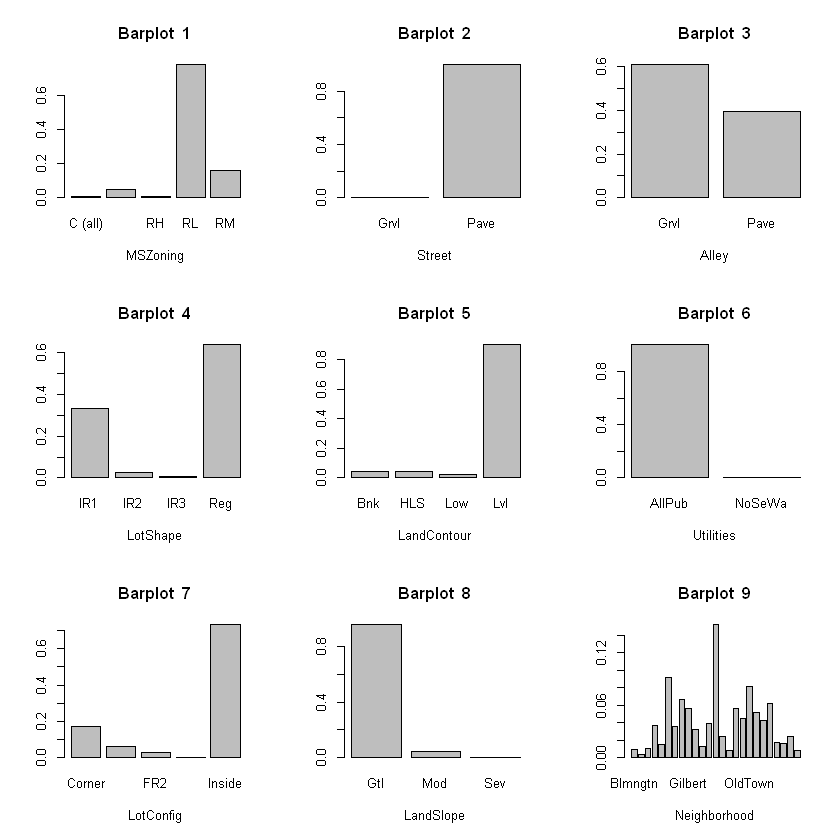

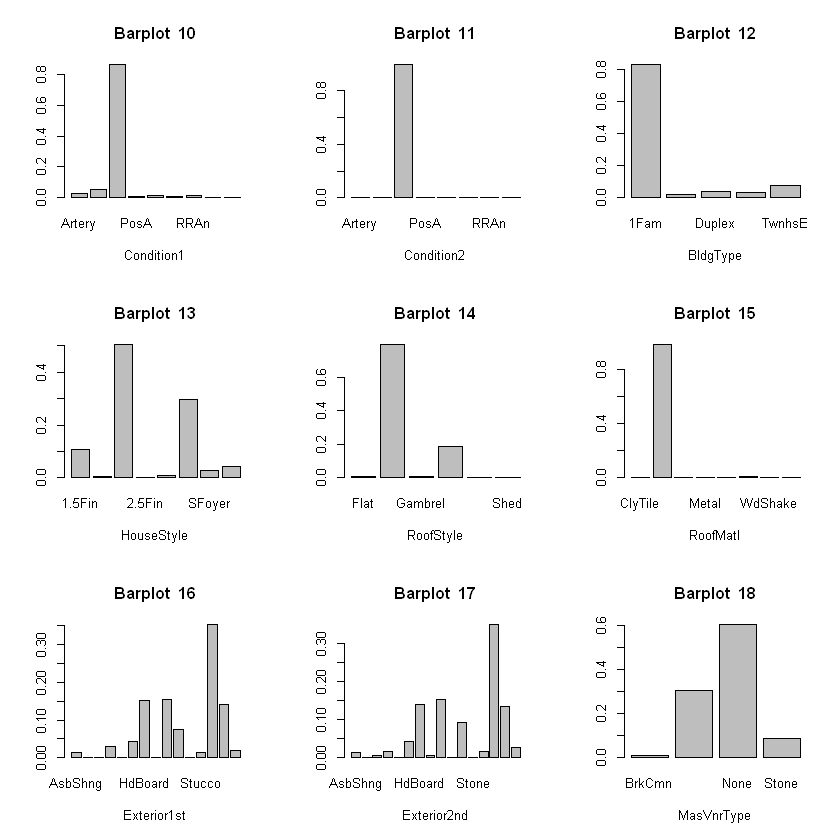

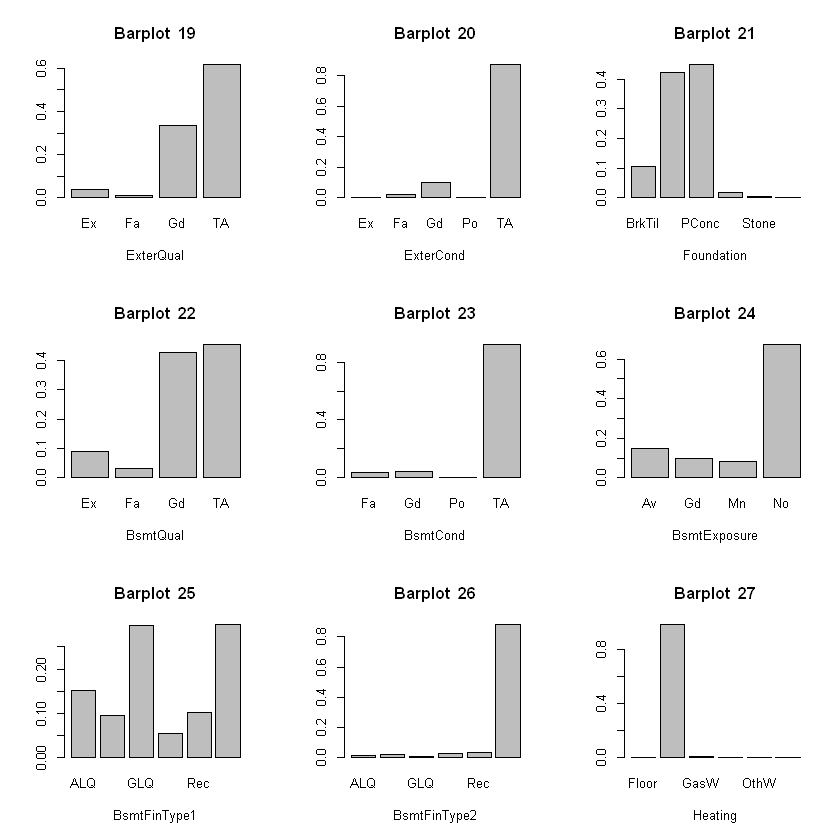

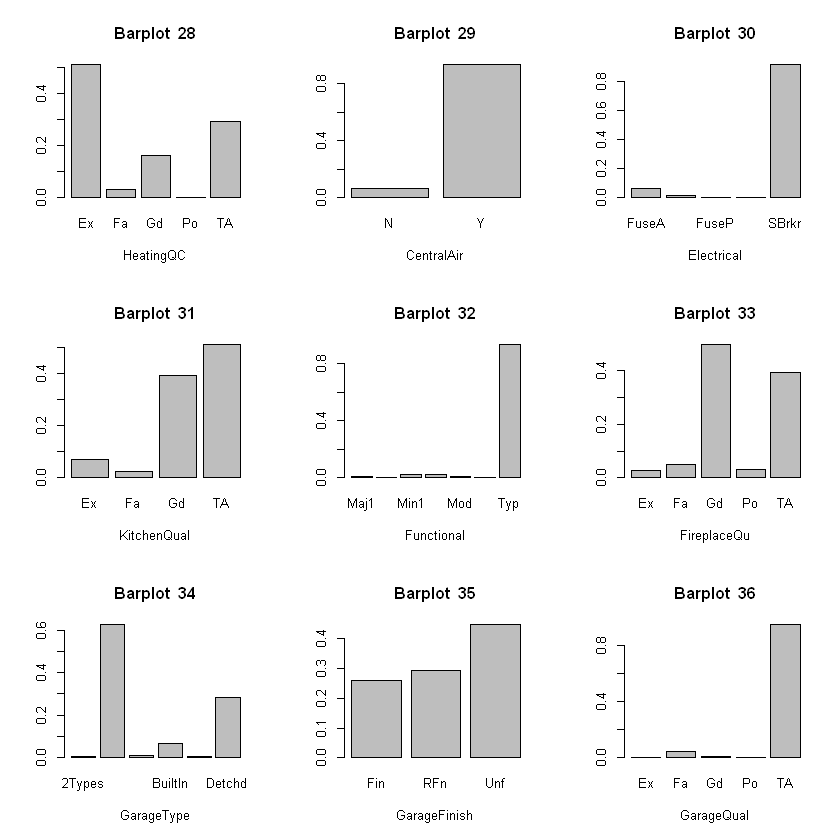

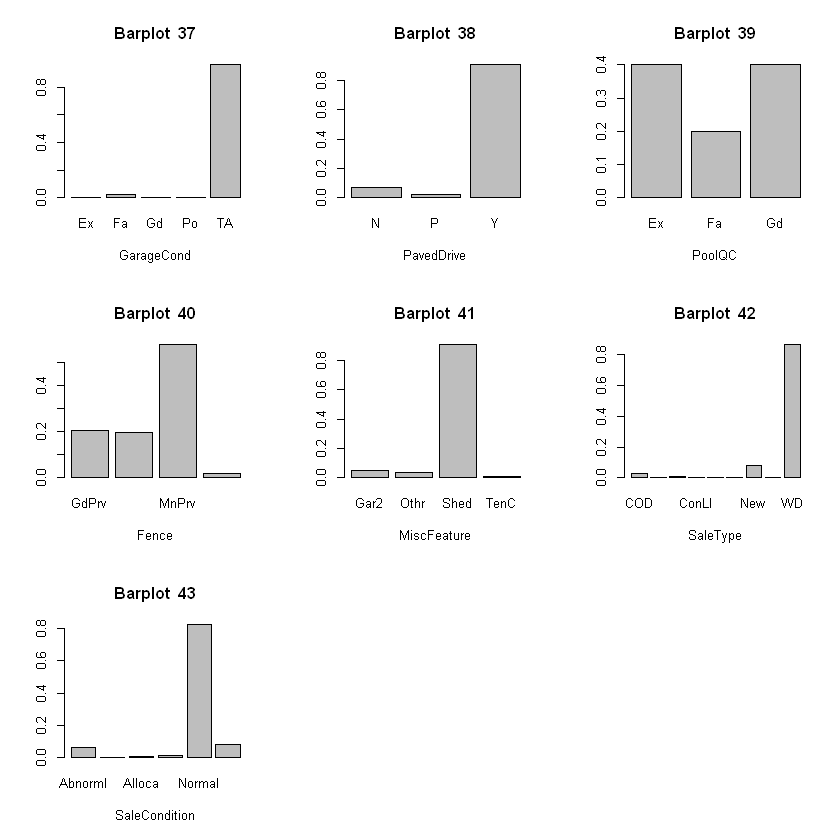

In [25]:
par(mfrow=c(3,3))
plotHist(categoric.df, 1:ncol(categoric.df))

By looking at the histograms for categorical data remove all feature where most values fall into 1 cat:

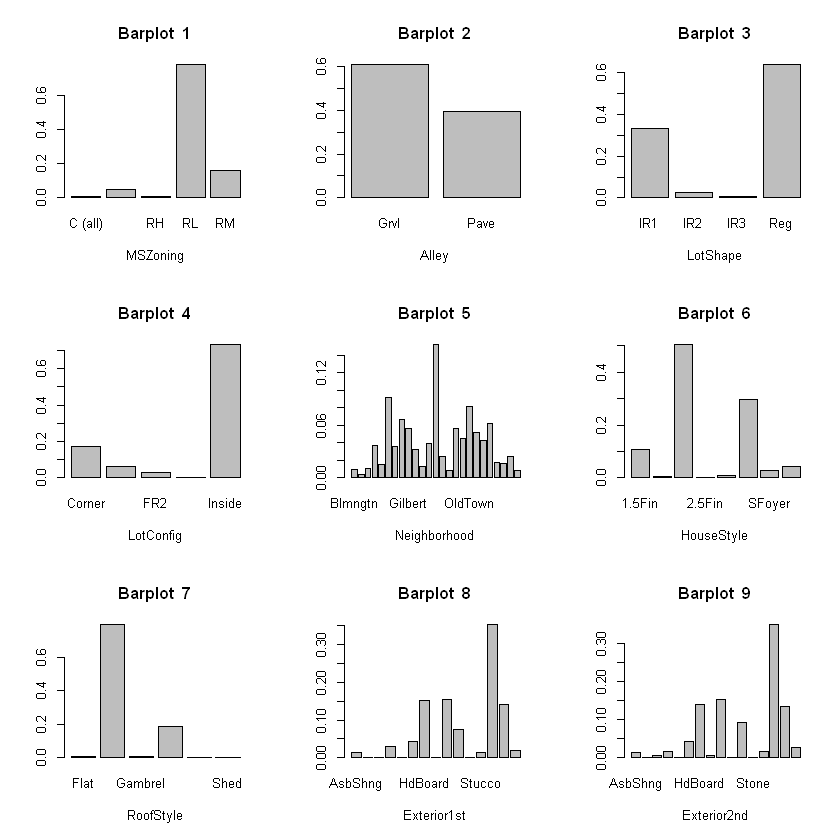

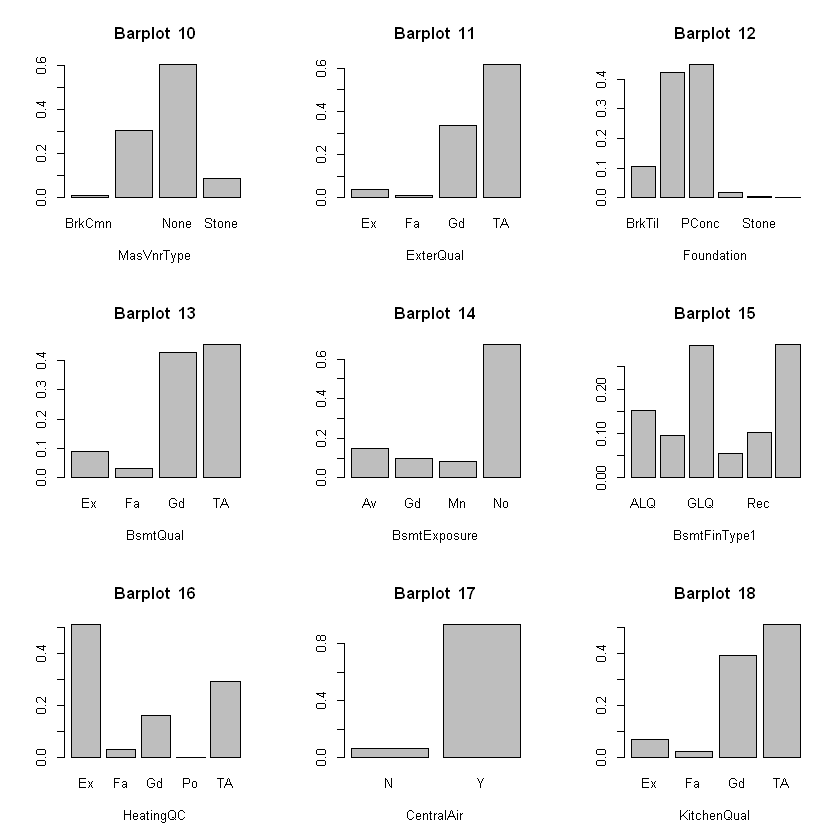

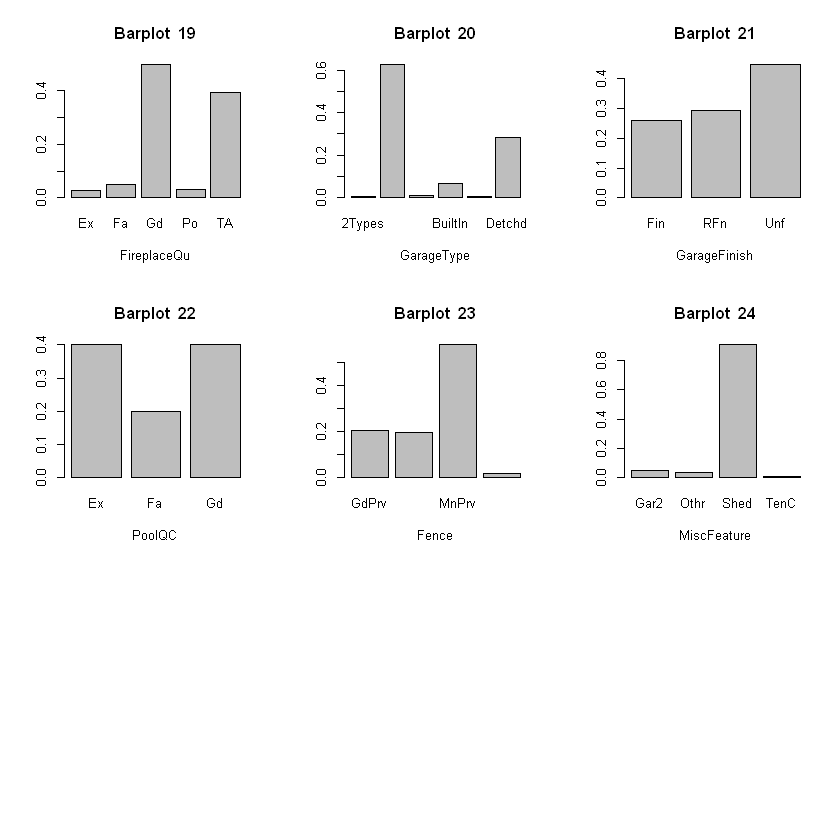

In [28]:
one_dominant_feature <- c('Street',"LandContour","Utilities", "LandSlope", 'Condition1', 'Condition2', 'BldgType', 'RoofMatl',
                          'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'Electrical', 'Functional', 'GarageQual',
                          "GarageCond","PavedDrive" , "SaleType" , "SaleCondition")

categoric.df <- categoric.df[,setdiff(names(categoric.df), one_dominant_feature)]
par(mfrow=c(3,3))
plotHist(categoric.df, 1: ncol(categoric.df))

Remove all features for which we don't have enough data:

In [30]:
not_enough_data <- c('MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'GarageFinish', 'BsmtQual', 'BsmtExposure', 
                     'BsmtFinType1', 'MasVnrType', 'GarageType', 'CentralAir' , 'Alley')

categoric.df <- categoric.df[,setdiff(names(categoric.df), not_enough_data)]


colSums(is.na(categoric.df))

MSZoning     LotShape    LotConfig Neighborhood   HouseStyle    RoofStyle 
           4            0            0            0            0            0 
 Exterior1st  Exterior2nd    ExterQual   Foundation    HeatingQC  KitchenQual 
           1            1            0            0            0            1

Impute missing values with the most frequent value on the column:


In [32]:
categoric.df[is.na(categoric.df$MSZoning), 'MSZoning'] <-names(sort(table(categoric.df$MSZoning), decreasing = TRUE)[1])
categoric.df[is.na(categoric.df$Exterior1st), 'Exterior1st'] <-names(sort(table(categoric.df$Exterior1st), decreasing = TRUE)[1])
categoric.df[is.na(categoric.df$Exterior2nd), 'Exterior2nd'] <-names(sort(table(categoric.df$Exterior2nd), decreasing = TRUE)[1])
categoric.df[is.na(categoric.df$KitchenQual), 'KitchenQual'] <-names(sort(table(categoric.df$KitchenQual), decreasing = TRUE)[1])


#Make sure there are no missing values
colSums(is.na(categoric.df))

MSZoning     LotShape    LotConfig Neighborhood   HouseStyle    RoofStyle 
           0            0            0            0            0            0 
 Exterior1st  Exterior2nd    ExterQual   Foundation    HeatingQC  KitchenQual 
           0            0            0            0            0            0

One hot encoding phase:

In [35]:
dim(categoric.df)

#one hot encoding phase
data_factor_onehot <- dummy.data.frame(categoric.df, sep="_")
dim(data_factor_onehot)

[1] 2919   12

[1] 2919  103

### Numeric data visualisation and imputation 

In [37]:
colSums(is.na(numeric.df))
numeric.df$Id <-NULL #remove id

MSSubClass   LotFrontage       LotArea   OverallQual   OverallCond 
            0           486             0             0             0 
    YearBuilt  YearRemodAdd    MasVnrArea    BsmtFinSF1    BsmtFinSF2 
            0             0            23             1             1 
    BsmtUnfSF   TotalBsmtSF     X1stFlrSF     X2ndFlrSF  LowQualFinSF 
            1             1             0             0             0 
    GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath      HalfBath 
            0             2             2             0             0 
 BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd    Fireplaces   GarageYrBlt 
            0             0             0             0           159 
   GarageCars    GarageArea    WoodDeckSF   OpenPorchSF EnclosedPorch 
            1             1             0             0             0 
   X3SsnPorch   ScreenPorch      PoolArea       MiscVal        MoSold 
            0             0             0             0             0 
       YrSold 
            0

Let's find relationships between features.

All basement features seem to be related

In [47]:
if( 'BsmtFinSF1' %in% names(numeric.df) ){
    bsmt <- numeric.df[, c('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF')]
    bsmt$SumBsmt <- bsmt$BsmtFinSF1 + bsmt$BsmtFinSF2 + bsmt$BsmtUnfSF
    par(mfrow=c(1,1))
    corrplot(cor(bsmt,use="complete.obs"),type = 'upper', method='color', addCoef.col = 'green')
    #because TotalBsmtSF is totally corellated with the sum of 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF' we
    #can simplify our model by keeping just the total
    numeric.df$BsmtFinSF1 <- NULL  
    numeric.df$BsmtFinSF2 <- NULL 
    numeric.df$BsmtUnfSF <- NULL 
}


In [48]:
#Ground area surfaces also seem to be related
if( 'X1stFlrSF' %in% names(numeric.df) ){
    area <- numeric.df[, c('X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF', 'GrLivArea')]
    area$SumArea <- area$X1stFlrSF + area$X2ndFlrSF + area$LowQualFinSF
    par(mfrow=c(1,1))
    corrplot(cor(area,use="complete.obs"),type = 'upper', method='color', addCoef.col = 'green')
    #because GrLivArea is totally corellated with the sum of 'X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF' we
    #can simplify our model by keeping just the total
    numeric.df$X1stFlrSF <- NULL  
    numeric.df$X2ndFlrSF <- NULL 
    numeric.df$LowQualFinSF <- NULL 
}

In [50]:
#Remove features with a lot of missing data
numeric.df$LotFrontage <- NULL
numeric.df$GarageYrBlt <- NULL

In [52]:
#For remaining features let's impute with mean
replace_na_with_mean_value <- function(vec) {
  mean_vec <- mean(vec, na.rm = TRUE)
  vec[is.na(vec)] <- mean_vec
  vec
}


numeric.df <- data.frame(apply(numeric.df, 2, replace_na_with_mean_value))

At this point we have no missing data!

In [109]:
colSums(is.na(numeric.df))

MSSubClass       LotArea   OverallQual   OverallCond     YearBuilt 
            0             0             0             0             0 
 YearRemodAdd    MasVnrArea   TotalBsmtSF     GrLivArea  BsmtFullBath 
            0             0             0             0             0 
 BsmtHalfBath      FullBath      HalfBath  BedroomAbvGr  KitchenAbvGr 
            0             0             0             0             0 
 TotRmsAbvGrd    Fireplaces    GarageCars    GarageArea    WoodDeckSF 
            0             0             0             0             0 
  OpenPorchSF EnclosedPorch    X3SsnPorch   ScreenPorch      PoolArea 
            0             0             0             0             0 
      MiscVal        MoSold        YrSold 
            0             0             0

Let's combine both numeric and one hot encoding values in one dataset.

In [94]:
data <- cbind(numeric.df, data_factor_onehot)
str(data)


'data.frame':	2919 obs. of  131 variables:
 $ MSSubClass          : num  60 20 60 70 60 50 20 60 50 190 ...
 $ LotArea             : num  8450 9600 11250 9550 14260 ...
 $ OverallQual         : num  7 6 7 7 8 5 8 7 7 5 ...
 $ OverallCond         : num  5 8 5 5 5 5 5 6 5 6 ...
 $ YearBuilt           : num  2003 1976 2001 1915 2000 ...
 $ YearRemodAdd        : num  2003 1976 2002 1970 2000 ...
 $ MasVnrArea          : num  196 0 162 0 350 0 186 240 0 0 ...
 $ TotalBsmtSF         : num  856 1262 920 756 1145 ...
 $ GrLivArea           : num  1710 1262 1786 1717 2198 ...
 $ BsmtFullBath        : num  1 0 1 1 1 1 1 1 0 1 ...
 $ BsmtHalfBath        : num  0 1 0 0 0 0 0 0 0 0 ...
 $ FullBath            : num  2 2 2 1 2 1 2 2 2 1 ...
 $ HalfBath            : num  1 0 1 0 1 1 0 1 0 0 ...
 $ BedroomAbvGr        : num  3 3 3 3 4 1 3 3 2 2 ...
 $ KitchenAbvGr        : num  1 1 1 1 1 1 1 1 2 2 ...
 $ TotRmsAbvGrd        : num  8 6 6 7 9 5 7 7 8 5 ...
 $ Fireplaces          : num  0 1 1 1 1 0 1 2 2 

### Ouput overview

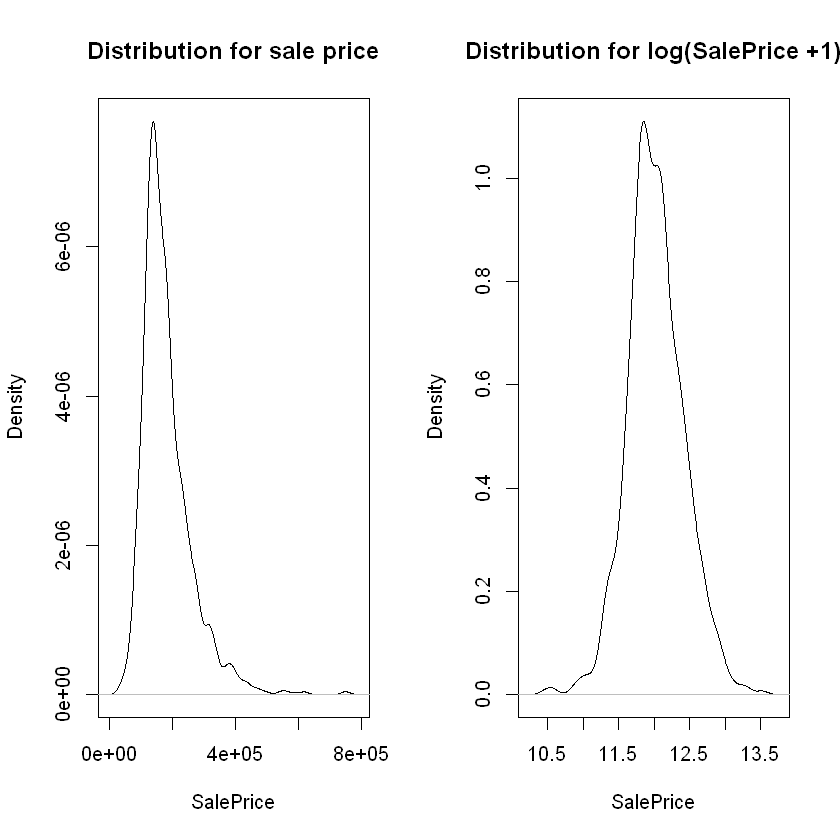

In [56]:
par(mfrow=c(1,2))
#let's examine the output
plot(density(input$SalePrice), xlab = 'SalePrice', 'Distribution for sale price') 
#the distribution of sale prices is right-skewed and does not follow a gaussian
plot(density(log(input$SalePrice + 1)), xlab = 'SalePrice', 'Distribution for log(SalePrice +1)')

In [95]:
X<- data[1:nrow(input),]
Y<-log(input$SalePrice + 1)
N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables

train<-cbind(X ,SalePrice=Y)
test <- data[(nrow(input) + 1):nrow(numeric.df),]
test <- cbind(numeric.df[(nrow(input) + 1):nrow(numeric.df),] , data_factor_onehot[(nrow(input) + 1):nrow(numeric.df),]) 

Let's check dependencies between features and SalePrice:


In [59]:
plotOutputDependency <- function(data_in, output, positions) {
  for (i in positions) {
    plot(data_in[[i]], output, xlab = colnames(data_in)[i], ylab = 'SalePrice', main = paste('Dependency ' , i))
  }
}

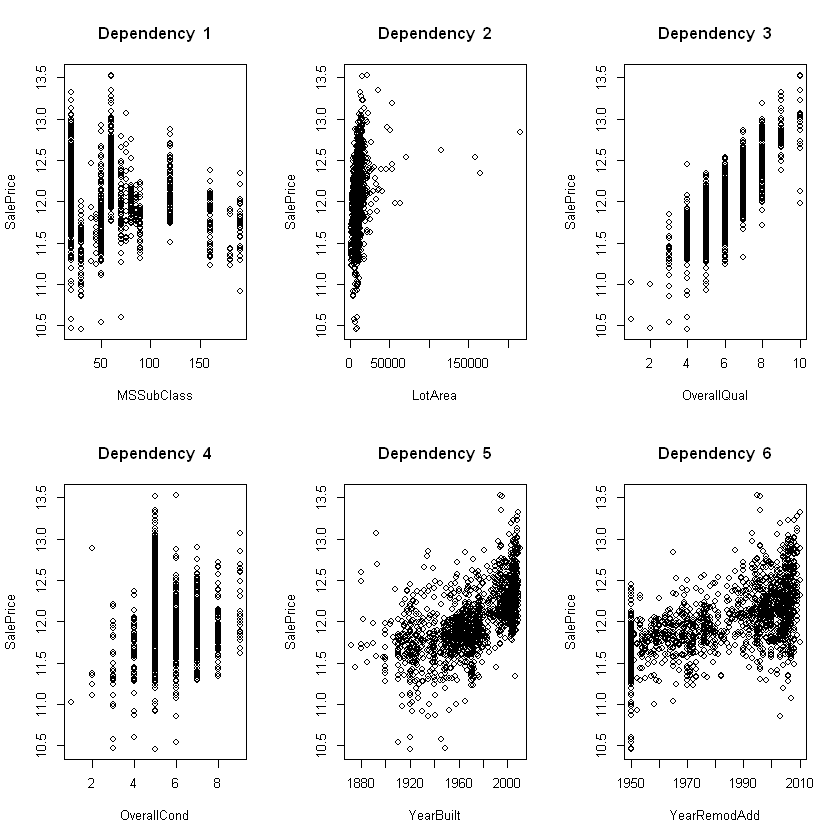

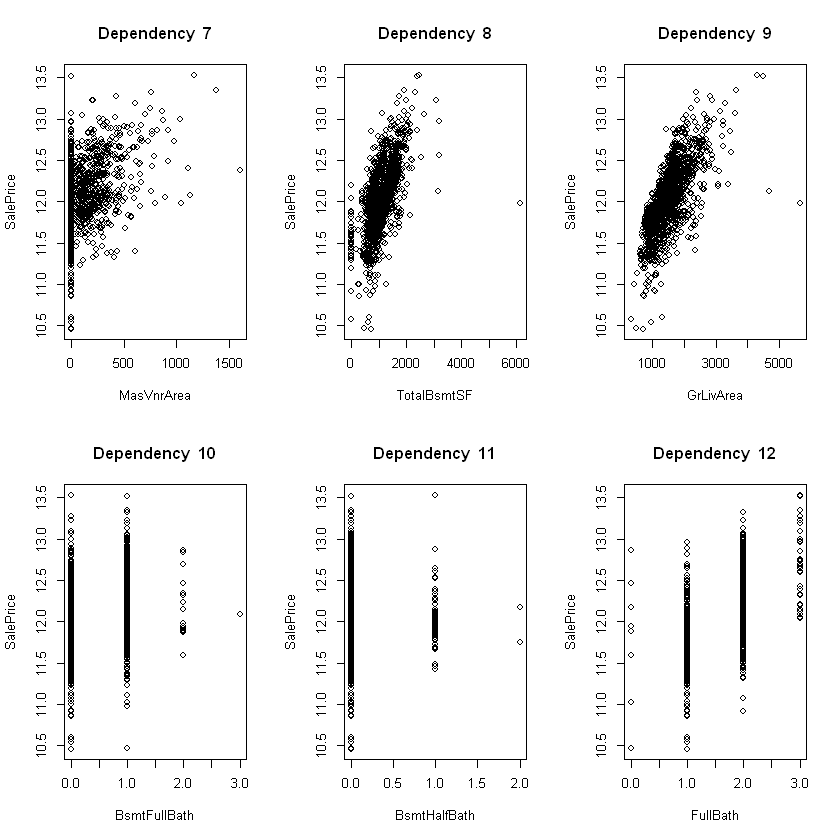

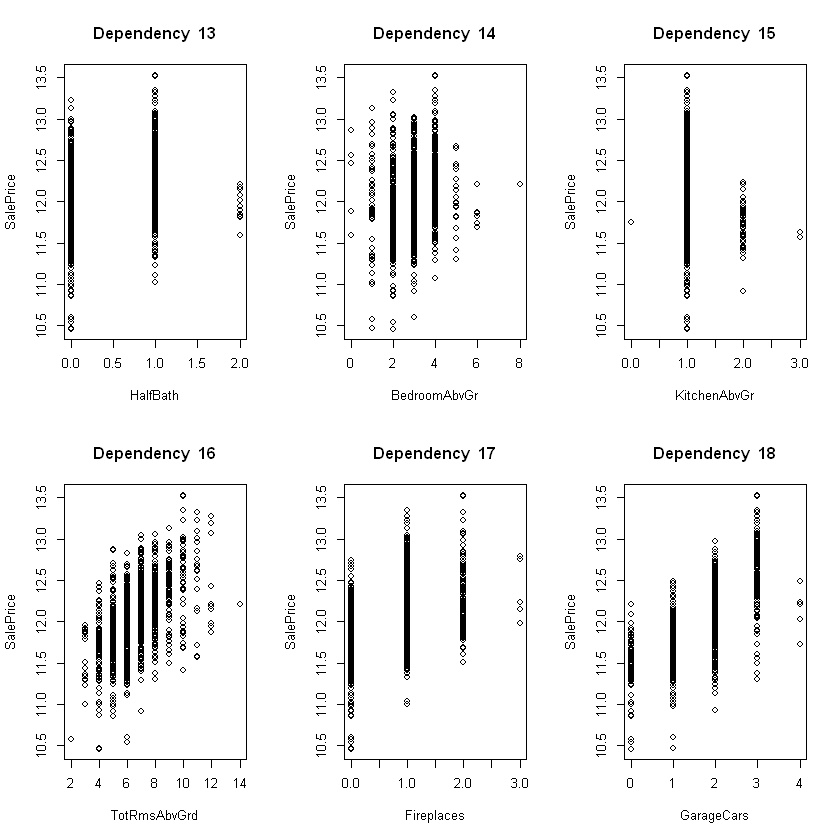

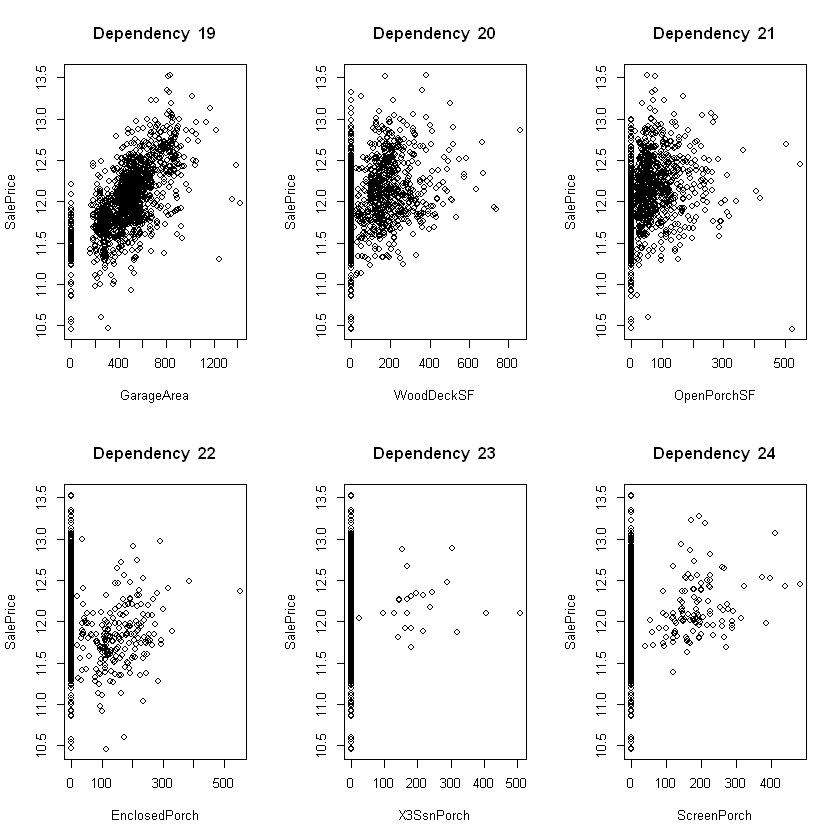

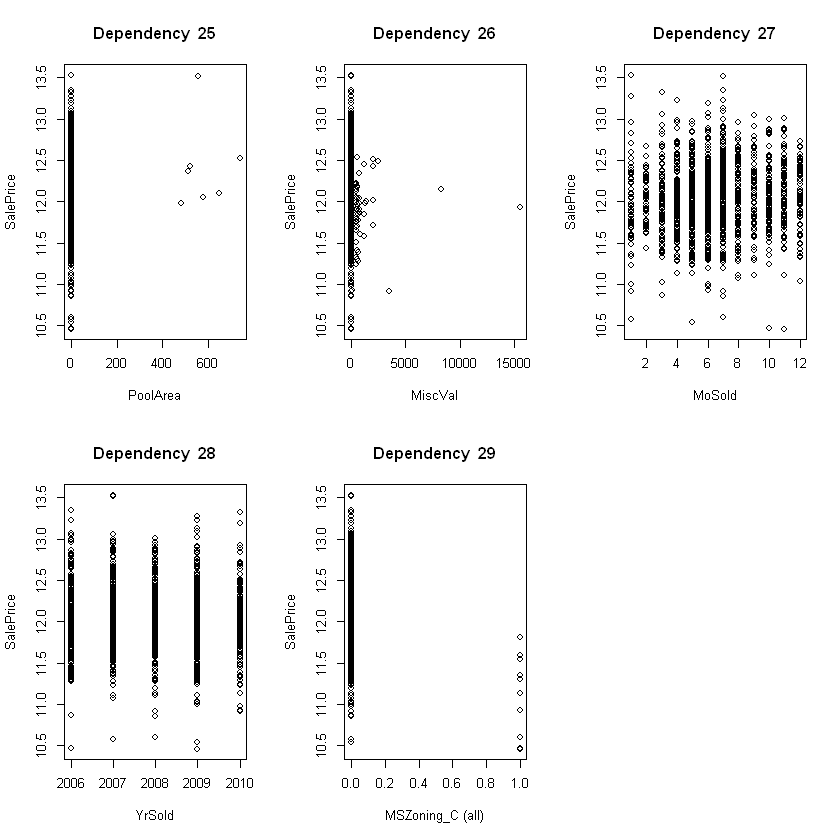

In [96]:
par(mfrow=c(2,3))
plotOutputDependency(X, Y, 1:29)

[1] 14

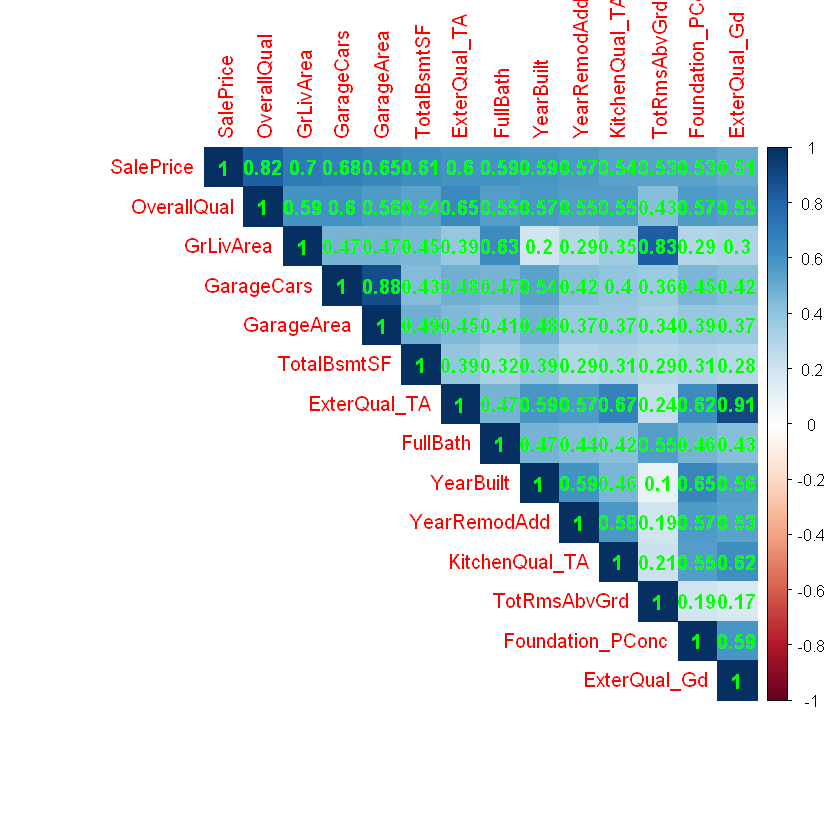

In [105]:
corr.df = cbind(X, SalePrice = Y)
correlations <- abs(cor(corr.df))

# only want the columns that show strong correlations with SalePrice, bigger than 0.5
corr.SalePrice = as.matrix(sort(correlations[,'SalePrice'], decreasing = TRUE))
corr.idx = names(which(apply(corr.SalePrice, 1, function(x) (x > 0.5))))

par(mfrow=c(1,1))
corrplot(as.matrix(correlations[corr.idx,corr.idx]), type = 'upper', method='color', addCoef.col = 'green')
    
length(corr.idx) #we have 14 features with a significative correlation with SalePrice
    

In [106]:
data <- data[, which(apply(corr.SalePrice, 1, function(x) (x > 0.2)))]
X<- data[1:nrow(input),]
Y<-log(input$SalePrice + 1)
N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables

`geom_smooth()` using method = 'gam'


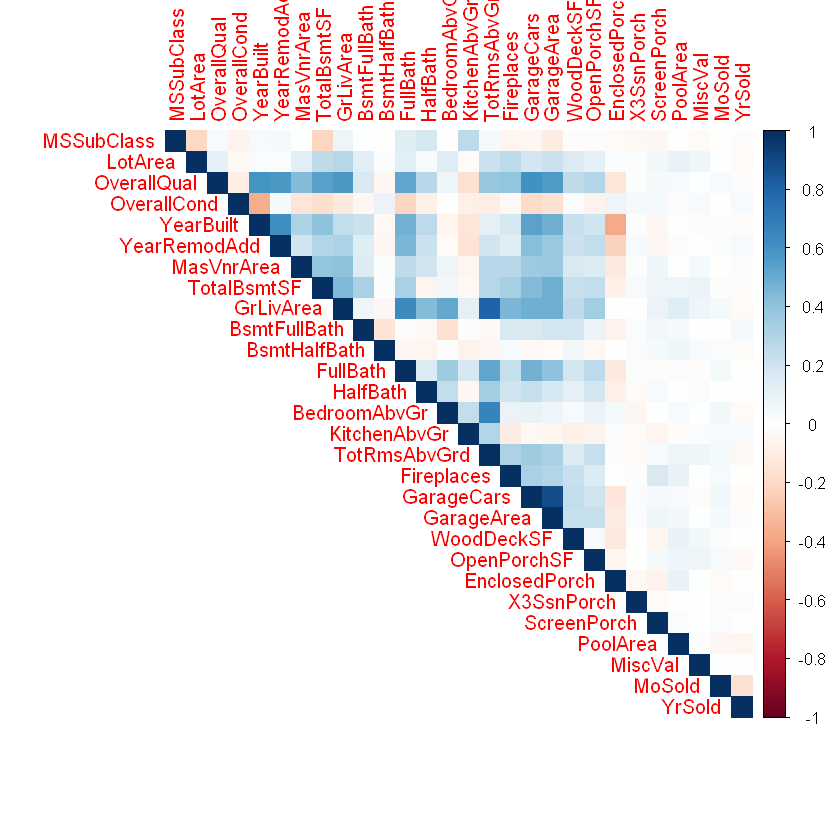

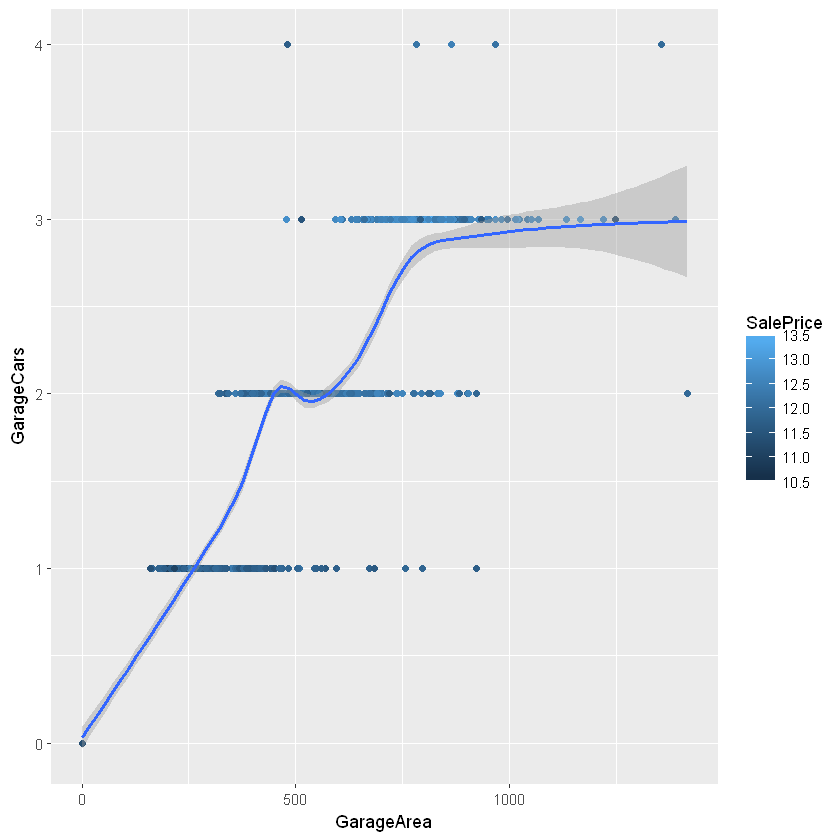

In [62]:
#Explore possible correlations between parameters
corrplot(cor(numeric.df,use="complete.obs"),type = 'upper', method='color')

ggplot(train, aes(x = GarageArea, y = GarageCars, color = SalePrice)) +
  geom_point() + geom_smooth()+ scale_fill_brewer(palette = "Spectral")

There are some dependencies we can explore in order to reduce features, for instance GarageArea is liniarly dependent on GarageCars.

We can do the same thing for categorical data too.

The root mean squared error function between the logarithm of the predicted value and the logarithm of the observed sales price to evaluate model performance:

In [122]:
rmse <- function (log_prediction, log_observation){
  sqrt(mean(log_prediction-log_observation)^2)
}


## Feature selection


In [123]:

filterFeatures <- function(modelName, X, Y){
  n <- ncol(X)
  size.CV<-floor(N/10)

  CV.err<-matrix(0,nrow=n,ncol=10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  


    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]

    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]

    #sometimes in the sampling process sd is 0 so let's remove those features because
    #calculating corelation on them would be a division by 0
    #X.tr <- X.tr[,which(apply(X.tr, 2, sd)!=0)]
    correlation<-abs(cor(X.tr,Y.tr))
    ranking<-sort(correlation,dec=T,index.return=T)$ix

    for (nb_features in 1:length(ranking)) {
      DS<-cbind(X.tr[,ranking[1:nb_features],drop=F],SalePrice=Y.tr)
      
      if(modelName == 'lm') {
        model<- lm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'rpart') {
        model<- rpart(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'tree') {
        model<- tree(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'svm'){
        # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
        #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
        model<- svm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'nnet'){
        DS <- scale(DS)
        model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'lazy'){
        model<- lazy(SalePrice~.,DS)
        Y.hat.ts<- predict(model,X.ts[,ranking[1:nb_features],drop=F])$h
      }
      
      CV.err[nb_features,i]<-rmse(Y.hat.ts,Y.ts)
    }
  }  
  
  par(mfrow=c(1,1))
  plot(1:nrow(CV.err),apply(CV.err,1,mean), type = "o", main = paste(modelName ,' selection'), xlab = "number of features", ylab = 'cross validaton error' )

  writeLines(paste( modelName, " filter features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))
}


In [126]:
X <- numeric.df

In [124]:
X <- data

lm  filter features:  1  ; CV error= 0.0103  ; std dev= 0.0083
lm  filter features:  2  ; CV error= 0.0085  ; std dev= 0.0071
lm  filter features:  3  ; CV error= 0.0093  ; std dev= 0.0065
lm  filter features:  4  ; CV error= 0.0089  ; std dev= 0.0059
lm  filter features:  5  ; CV error= 0.0092  ; std dev= 0.0076
lm  filter features:  6  ; CV error= 0.0087  ; std dev= 0.0082
lm  filter features:  7  ; CV error= 0.0083  ; std dev= 0.0073
lm  filter features:  8  ; CV error= 0.0083  ; std dev= 0.0078
lm  filter features:  9  ; CV error= 0.0084  ; std dev= 0.008
lm  filter features:  10  ; CV error= 0.0106  ; std dev= 0.0075
lm  filter features:  11  ; CV error= 0.0105  ; std dev= 0.0075
lm  filter features:  12  ; CV error= 0.0102  ; std dev= 0.0067
lm  filter features:  13  ; CV error= 0.01  ; std dev= 0.0067
lm  filter features:  14  ; CV error= 0.01  ; std dev= 0.0066
lm  filter features:  15  ; CV error= 0.0103  ; std dev= 0.0067
lm  filter features:  16  ; CV error= 0.0115  ; std de

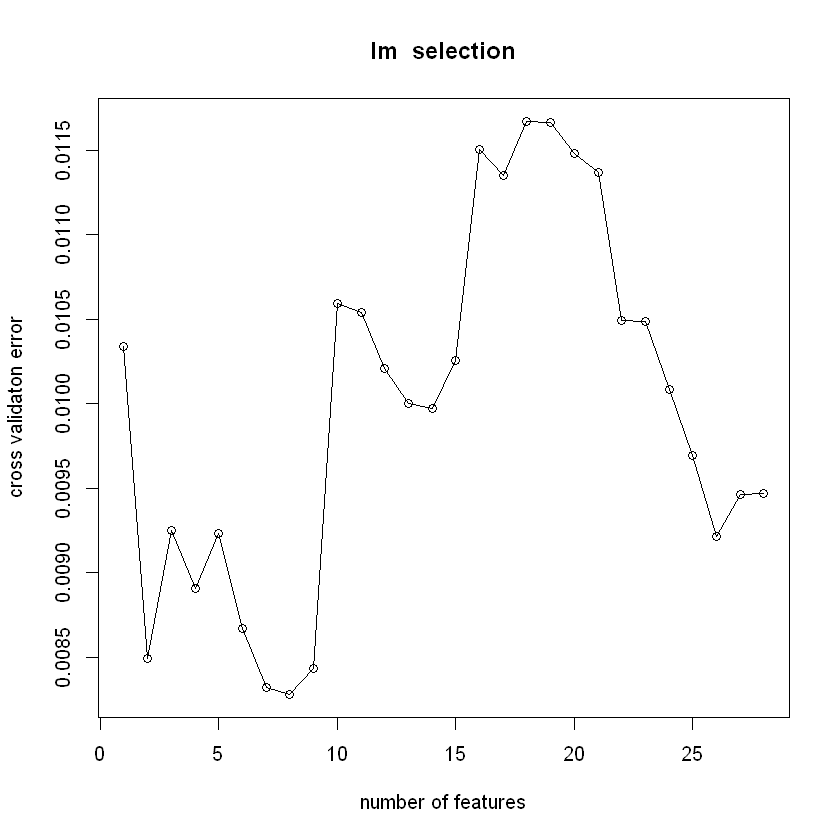

In [127]:
filterFeatures('lm', X, Y)

tree  filter features:  1  ; CV error= 0.0125  ; std dev= 0.0093
tree  filter features:  2  ; CV error= 0.0162  ; std dev= 0.0101
tree  filter features:  3  ; CV error= 0.0139  ; std dev= 0.0101
tree  filter features:  4  ; CV error= 0.0133  ; std dev= 0.0101
tree  filter features:  5  ; CV error= 0.0141  ; std dev= 0.0117
tree  filter features:  6  ; CV error= 0.0146  ; std dev= 0.0111
tree  filter features:  7  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  8  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  9  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  10  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  11  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  12  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  13  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  14  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter features:  15  ; CV error= 0.0142  ; std dev= 0.0121
tree  filter featur

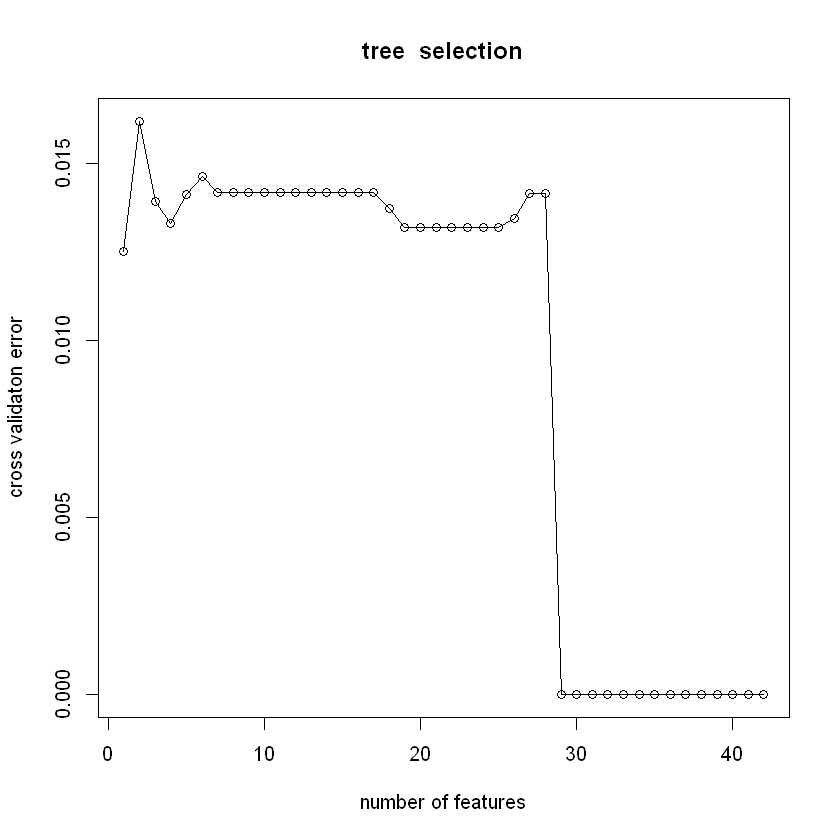

In [119]:
filterFeatures('tree', X, Y)

In [114]:
filterFeatures('lazy', X, Y)

ERROR: Error in `[.data.frame`(mf, , nmx, drop = FALSE): undefined columns selected


# weights:  10
initial  value 1818.192743 
iter  10 value 442.040765
iter  20 value 438.572379
iter  30 value 436.401145
iter  40 value 435.673684
iter  50 value 435.357013
iter  60 value 435.284447
iter  70 value 435.283202
final  value 435.283084 
converged
# weights:  13
initial  value 1137.767464 
iter  10 value 330.623068
iter  20 value 321.431104
iter  30 value 320.664087
iter  40 value 319.251553
iter  50 value 318.537949
iter  60 value 318.409917
iter  70 value 318.388502
final  value 318.388476 
converged
# weights:  16
initial  value 1511.309025 
iter  10 value 315.840090
iter  20 value 293.955015
iter  30 value 282.696177
iter  40 value 281.505510
iter  50 value 279.654415
iter  60 value 279.370980
iter  70 value 279.357250
iter  80 value 279.356617
iter  80 value 279.356615
iter  80 value 279.356615
final  value 279.356615 
converged
# weights:  19
initial  value 2254.933373 
iter  10 value 321.144447
iter  20 value 288.904691
iter  30 value 276.739143
iter  40 value 270.47

nnet  filter features:  1  ; CV error= 9.4288  ; std dev= 0.0932
nnet  filter features:  2  ; CV error= 11.0743  ; std dev= 0.5054
nnet  filter features:  3  ; CV error= 10.7626  ; std dev= 1.3175
nnet  filter features:  4  ; CV error= 12.0659  ; std dev= 0.7526
nnet  filter features:  5  ; CV error= 10.9948  ; std dev= 0.6063
nnet  filter features:  6  ; CV error= 11.9337  ; std dev= 0.8846
nnet  filter features:  7  ; CV error= 10.1388  ; std dev= 1.0519
nnet  filter features:  8  ; CV error= 9.5184  ; std dev= 0.5644
nnet  filter features:  9  ; CV error= 9.35  ; std dev= 0.6837
nnet  filter features:  10  ; CV error= 9.9399  ; std dev= 1.1509
nnet  filter features:  11  ; CV error= 9.79  ; std dev= 1.1916
nnet  filter features:  12  ; CV error= 10.427  ; std dev= 1.0028
nnet  filter features:  13  ; CV error= 10.6648  ; std dev= 1.2892
nnet  filter features:  14  ; CV error= 10.5726  ; std dev= 0.9637
nnet  filter features:  15  ; CV error= 10.7574  ; std dev= 0.8868
nnet  filter f

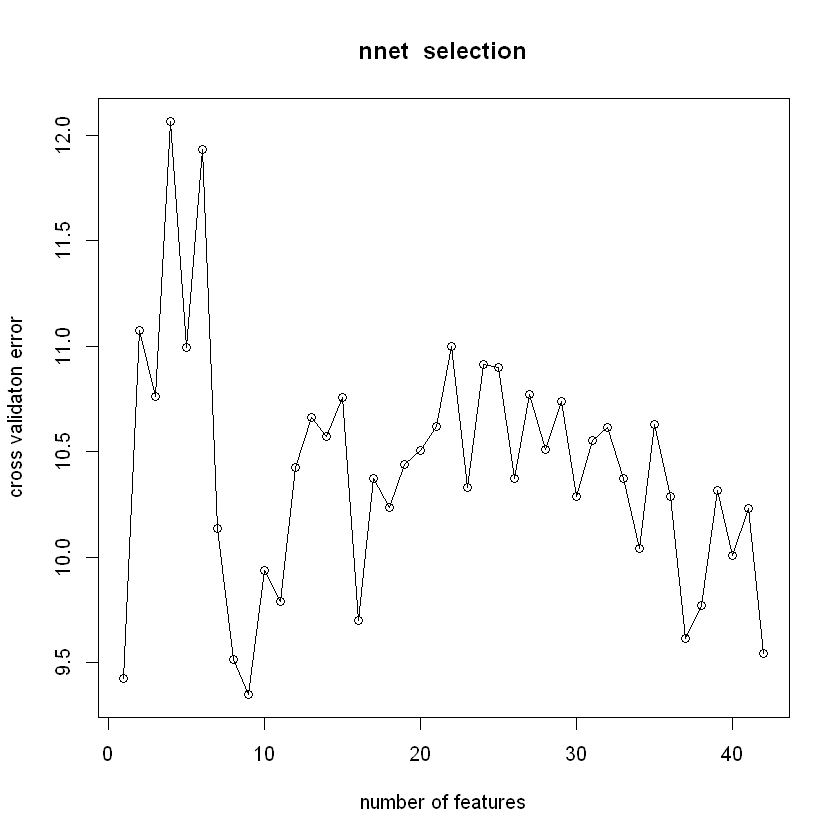

In [112]:
filterFeatures('nnet', X, Y)

rpart  features:  1  ; CV error= 0.0127  ; std dev= 0.0098
rpart  features:  2  ; CV error= 0.0162  ; std dev= 0.0101
rpart  features:  3  ; CV error= 0.0139  ; std dev= 0.0101
rpart  features:  4  ; CV error= 0.0133  ; std dev= 0.0101
rpart  features:  5  ; CV error= 0.0141  ; std dev= 0.0117
rpart  features:  6  ; CV error= 0.0146  ; std dev= 0.0111
rpart  features:  7  ; CV error= 0.0142  ; std dev= 0.0121
rpart  features:  8  ; CV error= 0.0142  ; std dev= 0.0121
rpart  features:  9  ; CV error= 0.0142  ; std dev= 0.0121
rpart  features:  10  ; CV error= 0.0142  ; std dev= 0.0121
rpart  features:  11  ; CV error= 0.0142  ; std dev= 0.0121
rpart  features:  12  ; CV error= 0.0139  ; std dev= 0.0122
rpart  features:  13  ; CV error= 0.0139  ; std dev= 0.0122
rpart  features:  14  ; CV error= 0.0139  ; std dev= 0.0122
rpart  features:  15  ; CV error= 0.0139  ; std dev= 0.0122
rpart  features:  16  ; CV error= 0.0139  ; std dev= 0.0122
rpart  features:  17  ; CV error= 0.0139  ; std d

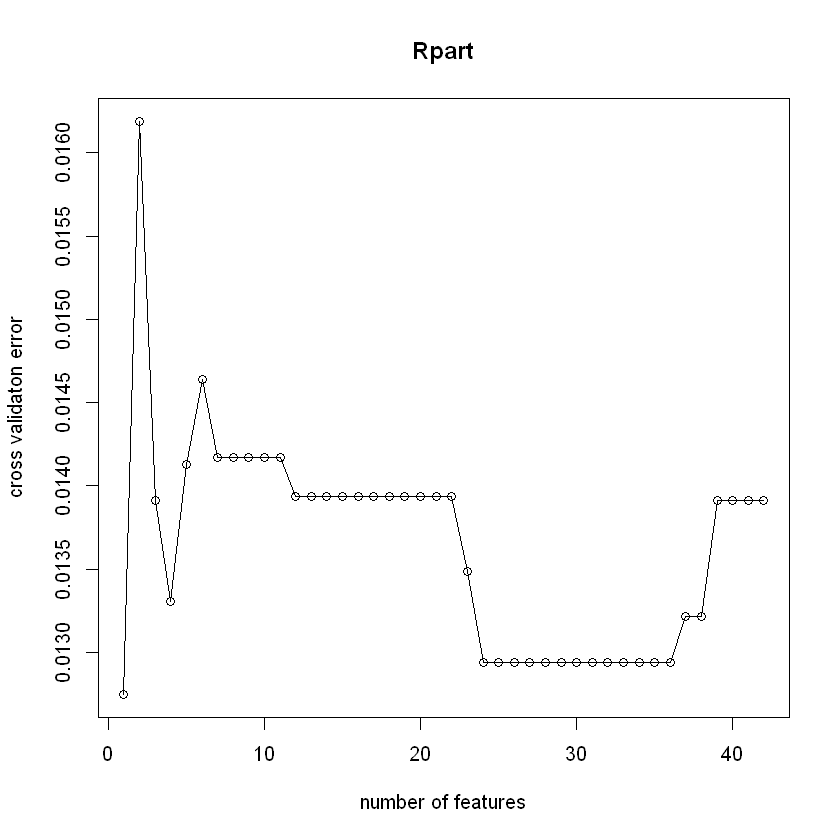

In [108]:
filterFeatures('rpart', X, Y)

The minimum redundancy maximum relevance feature selection strategy approximates


\begin{equation}
  \arg\max_{x_{k}\in X - X_{S}} \left(I\left\{X_{S}; x_{k}\right\};y\right)
\end{equation}


with


\begin{equation}
  x^*_{MRMR}=\arg\max_{x_{k}\in X - X_{S}} \left[I(x_{k}; y) - \frac{1}{m} \sum_{x_{i}\in X_{S}} I(x_{i}; x_{k})\right]
\end{equation}

where $m$ is the size of $X_S$


In [128]:

mrmr <- function(modelName, X, Y) {
  n <- ncol(X)
  size.CV<-floor(N/10)
  
  CV.err<-matrix(0,nrow=n,ncol=10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]
    
    
    correlation<-abs(cor(X.tr,Y.tr))
    
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
      redudancy.score<-numeric(length(candidates))
      if (length(selected)>0) {
        cor.selected.candidates<-cor(X.tr[,selected,drop=F],X.tr[,candidates,drop=F])
        redudancy.score<-apply(cor.selected.candidates,2,mean)
      }
      
      mRMR.score<-correlation[candidates]-redudancy.score
      #print(paste('redudancy.score : ', redudancy.score, '  correlation[candidates] : ', correlation[candidates]))
      selected_current<-candidates[which.max(mRMR.score)]
      selected<-c(selected,selected_current)
      candidates<-setdiff(candidates,selected_current)
      #print(paste(' mRMR.score: ', mRMR.score, ' selected_current : ', selected_current, ' selected :' , selected, ' candidates: ', candidates))
    }
    
    ranking<-selected
    
    for (nb_features in 1:n) {
      DS<-cbind(X.tr[,ranking[1:nb_features],drop=F],SalePrice=Y.tr)
      
      if(modelName == 'lm') {
        model<- lm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'rpart') {
        model<- rpart(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'tree') {
        model<- tree(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'svm'){
        # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
        #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
        model<- svm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'nnet'){
        DS <- scale(DS)
        model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
        Y.hat.ts <- predict(model,X.ts[,ranking[1:nb_features],drop=F])
      }
      if(modelName == 'lazy'){
        model<- lazy(SalePrice~.,DS)
        Y.hat.ts<- predict(model,X.ts[,ranking[1:nb_features],drop=F])$h
      }
      
      CV.err[nb_features,i]<-rmse(Y.hat.ts,Y.ts)
    }
  }  
  
  par(mfrow=c(1,1))
  plot(1:nrow(CV.err),apply(CV.err,1,mean), type = "o", main = paste(modelName ,' MRMR'), xlab = "number of features", ylab = 'cross validaton error' )
  
  writeLines(paste(modelName , "Features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))
  print(selected)
  selected
}

lm Features:  1  ; CV error= 0.0103  ; std dev= 0.0083
lm Features:  2  ; CV error= 0.0102  ; std dev= 0.0084
lm Features:  3  ; CV error= 0.0105  ; std dev= 0.0068
lm Features:  4  ; CV error= 0.0093  ; std dev= 0.0062
lm Features:  5  ; CV error= 0.0083  ; std dev= 0.0063
lm Features:  6  ; CV error= 0.0079  ; std dev= 0.0053
lm Features:  7  ; CV error= 0.0073  ; std dev= 0.0058
lm Features:  8  ; CV error= 0.0078  ; std dev= 0.0067
lm Features:  9  ; CV error= 0.0096  ; std dev= 0.0073
lm Features:  10  ; CV error= 0.0101  ; std dev= 0.0072
lm Features:  11  ; CV error= 0.01  ; std dev= 0.0074
lm Features:  12  ; CV error= 0.0107  ; std dev= 0.007
lm Features:  13  ; CV error= 0.01  ; std dev= 0.007
lm Features:  14  ; CV error= 0.0101  ; std dev= 0.0063
lm Features:  15  ; CV error= 0.0102  ; std dev= 0.0063
lm Features:  16  ; CV error= 0.0116  ; std dev= 0.0073
lm Features:  17  ; CV error= 0.0116  ; std dev= 0.0073
lm Features:  18  ; CV error= 0.0116  ; std dev= 0.0085
lm Feat

[1]  3 15 18  9  5  8 22  6 17 19 12 16  7 20 13 10 21  2  4 24 14  1 28 27 26
[26] 23 25 11

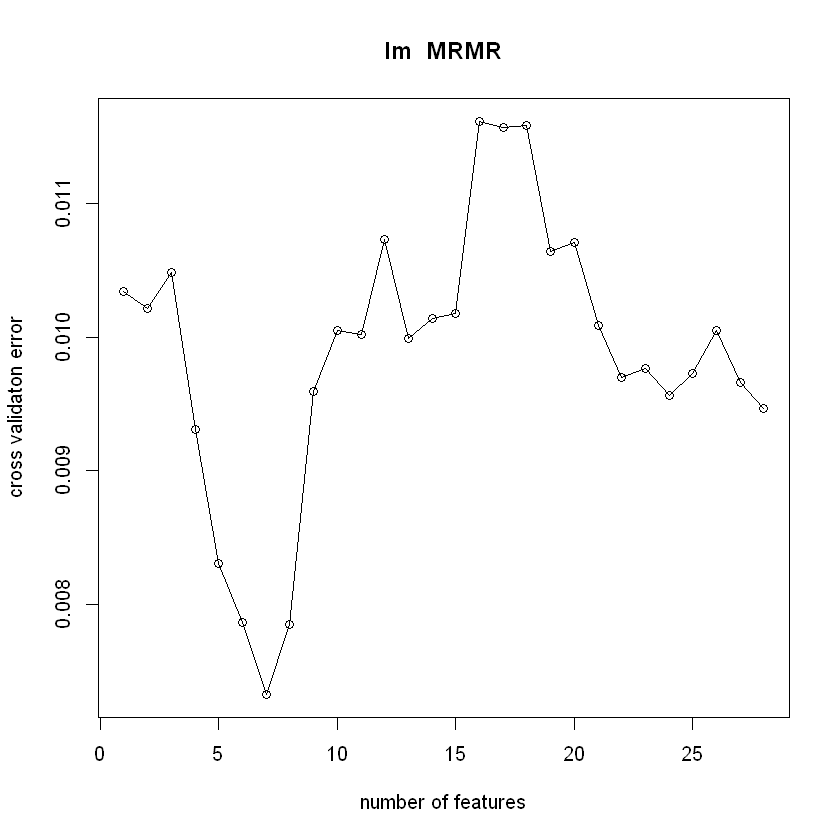

In [130]:
mrmr('lm', X, Y)

tree Features:  1  ; CV error= 0.0125  ; std dev= 0.0093
tree Features:  2  ; CV error= 0.0125  ; std dev= 0.0093
tree Features:  3  ; CV error= 0.0125  ; std dev= 0.0101
tree Features:  4  ; CV error= 0.0122  ; std dev= 0.0093
tree Features:  5  ; CV error= 0.0137  ; std dev= 0.0075
tree Features:  6  ; CV error= 0.0141  ; std dev= 0.0095
tree Features:  7  ; CV error= 0.0131  ; std dev= 0.0113
tree Features:  8  ; CV error= 0.0132  ; std dev= 0.0114
tree Features:  9  ; CV error= 0.0132  ; std dev= 0.0114
tree Features:  10  ; CV error= 0.0132  ; std dev= 0.0114
tree Features:  11  ; CV error= 0.0132  ; std dev= 0.0114
tree Features:  12  ; CV error= 0.0132  ; std dev= 0.0114
tree Features:  13  ; CV error= 0.0132  ; std dev= 0.0114
tree Features:  14  ; CV error= 0.0132  ; std dev= 0.0114
tree Features:  15  ; CV error= 0.0132  ; std dev= 0.0114
tree Features:  16  ; CV error= 0.0132  ; std dev= 0.0114
tree Features:  17  ; CV error= 0.0132  ; std dev= 0.0114
tree Features:  18  ; C

[1]  3 15 18  9  5  8 22  6 17 19 12 16  7 20 13 10 21  2  4 24 14  1 28 27 26
[26] 23 25 11

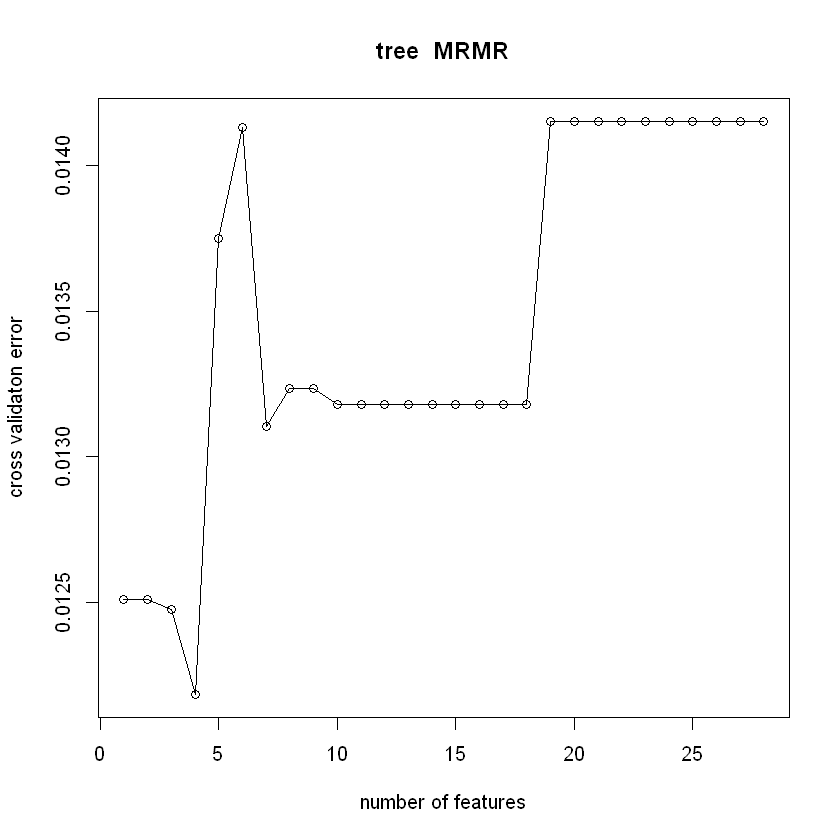

In [131]:
mrmr('tree', X, Y)

lazy Features:  1  ; CV error= 0.0161  ; std dev= 0.0112
lazy Features:  2  ; CV error= 0.0218  ; std dev= 0.0148
lazy Features:  3  ; CV error= 0.0448  ; std dev= 0.0536
lazy Features:  4  ; CV error= 0.1069  ; std dev= 0.083
lazy Features:  5  ; CV error= 0.0751  ; std dev= 0.065
lazy Features:  6  ; CV error= 0.0775  ; std dev= 0.0772
lazy Features:  7  ; CV error= 0.0991  ; std dev= 0.074
lazy Features:  8  ; CV error= 0.0866  ; std dev= 0.074
lazy Features:  9  ; CV error= 0.0836  ; std dev= 0.0546
lazy Features:  10  ; CV error= 0.0646  ; std dev= 0.049
lazy Features:  11  ; CV error= 0.065  ; std dev= 0.0562
lazy Features:  12  ; CV error= 0.0617  ; std dev= 0.052
lazy Features:  13  ; CV error= 0.0343  ; std dev= 0.0281
lazy Features:  14  ; CV error= 0.0364  ; std dev= 0.0462
lazy Features:  15  ; CV error= 0.0454  ; std dev= 0.0394
lazy Features:  16  ; CV error= 0.039  ; std dev= 0.0334
lazy Features:  17  ; CV error= 0.0337  ; std dev= 0.0349
lazy Features:  18  ; CV error=

[1]  3 15 18  9  5  8 22  6 17 19 12 16  7 20 13 10 21  2  4 24 14  1 28 27 26
[26] 23 25 11

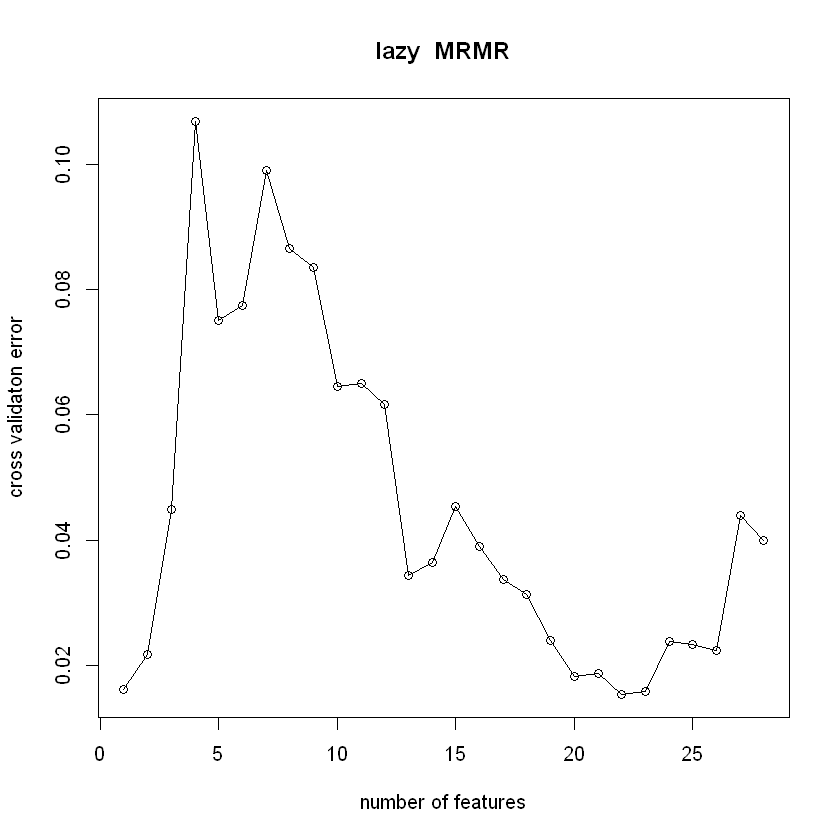

In [132]:
mrmr('lazy', X, Y)

svm Features:  1  ; CV error= 0.0152  ; std dev= 0.0103
svm Features:  2  ; CV error= 0.0144  ; std dev= 0.0103
svm Features:  3  ; CV error= 0.0156  ; std dev= 0.008
svm Features:  4  ; CV error= 0.017  ; std dev= 0.0095
svm Features:  5  ; CV error= 0.0144  ; std dev= 0.0093
svm Features:  6  ; CV error= 0.0141  ; std dev= 0.0082
svm Features:  7  ; CV error= 0.0128  ; std dev= 0.0064
svm Features:  8  ; CV error= 0.0134  ; std dev= 0.0083
svm Features:  9  ; CV error= 0.0134  ; std dev= 0.0082
svm Features:  10  ; CV error= 0.0137  ; std dev= 0.0096
svm Features:  11  ; CV error= 0.0144  ; std dev= 0.009
svm Features:  12  ; CV error= 0.0138  ; std dev= 0.0084
svm Features:  13  ; CV error= 0.0139  ; std dev= 0.0089
svm Features:  14  ; CV error= 0.0142  ; std dev= 0.0091
svm Features:  15  ; CV error= 0.0144  ; std dev= 0.0087
svm Features:  16  ; CV error= 0.0154  ; std dev= 0.0088
svm Features:  17  ; CV error= 0.0163  ; std dev= 0.0081
svm Features:  18  ; CV error= 0.0157  ; st

[1]  3 15 18  9  5  8 22  6 17 19 12 16  7 20 13 10 21  2  4 24 14  1 28 27 26
[26] 23 25 11

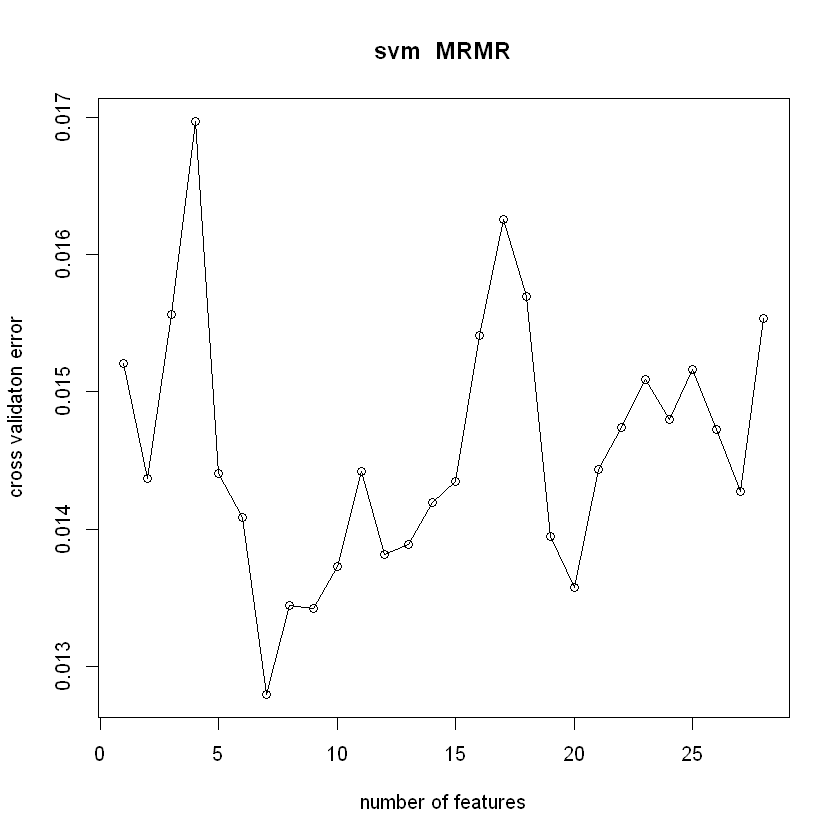

In [133]:
mrmr('svm', X, Y)

rpart Features:  1  ; CV error= 0.0127  ; std dev= 0.0098
rpart Features:  2  ; CV error= 0.0127  ; std dev= 0.0098
rpart Features:  3  ; CV error= 0.0124  ; std dev= 0.0099
rpart Features:  4  ; CV error= 0.0122  ; std dev= 0.0093
rpart Features:  5  ; CV error= 0.0137  ; std dev= 0.0075
rpart Features:  6  ; CV error= 0.0141  ; std dev= 0.0095
rpart Features:  7  ; CV error= 0.0131  ; std dev= 0.0113
rpart Features:  8  ; CV error= 0.0132  ; std dev= 0.0114
rpart Features:  9  ; CV error= 0.0132  ; std dev= 0.0114
rpart Features:  10  ; CV error= 0.0132  ; std dev= 0.0114
rpart Features:  11  ; CV error= 0.0132  ; std dev= 0.0114
rpart Features:  12  ; CV error= 0.0132  ; std dev= 0.0114
rpart Features:  13  ; CV error= 0.0132  ; std dev= 0.0114
rpart Features:  14  ; CV error= 0.0132  ; std dev= 0.0114
rpart Features:  15  ; CV error= 0.0132  ; std dev= 0.0114
rpart Features:  16  ; CV error= 0.0132  ; std dev= 0.0114
rpart Features:  17  ; CV error= 0.0132  ; std dev= 0.0114
rpart 

[1]  3 15 18  9  5  8 22  6 17 19 12 16  7 20 13 10 21  2  4 24 14  1 28 27 26
[26] 23 25 11

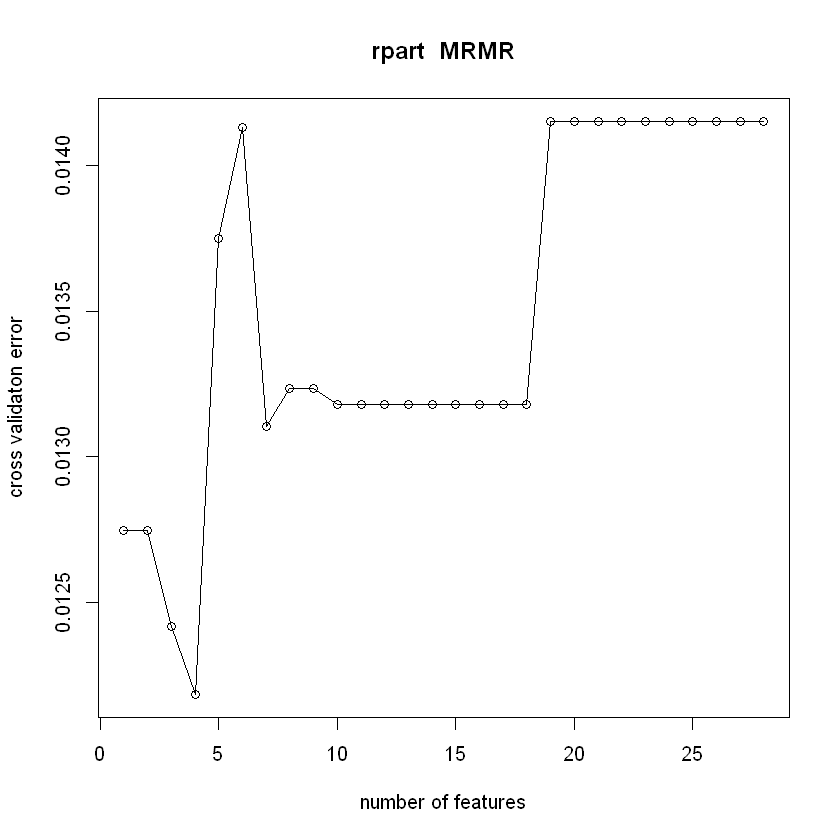

In [129]:
mrmr('rpart', X, Y)

In [134]:

pca <- function(modelName, X, Y) {
  n <- ncol(X)
  size.CV<-floor(N/10)
  
  CV.err<-matrix(0,nrow=n,ncol=10)
  
  X_pca<-data.frame(prcomp(X,retx=T)$x)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X_pca[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X_pca[i.tr,]
    Y.tr<-Y[i.tr]
    
    for (nb_features in 1:n) {
      DS<-cbind(X.tr[,1:nb_features,drop=F],SalePrice=Y.tr)
      
      if(modelName == 'lm') {
        model<- lm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'rpart') {
        model<- rpart(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'tree') {
        model<- tree(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'svm'){
        # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
        #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
        model<- svm(SalePrice~.,DS)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'nnet'){
        DS <- scale(DS)
        model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
        Y.hat.ts <- predict(model,X.ts[,1:nb_features,drop=F])
      }
      if(modelName == 'lazy'){
        model<- lazy(SalePrice~.,DS)
        Y.hat.ts<- predict(model,X.ts[,1:nb_features,drop=F])$h
      }
      
      CV.err[nb_features,i]<-rmse(Y.hat.ts,Y.ts)
    }
  }  
  par(mfrow=c(1,1))
  plot(1:nrow(CV.err),apply(CV.err,1,mean), type = "o", main = paste(modelName ,' PCA '), xlab = "number of features", ylab = 'cross validaton error' )
  
  writeLines(paste(modelName ," Features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))
  X_pca
}


In [ ]:
pca('rpart', X, Y)

In [ ]:
pca('svm', X, Y)

In [ ]:
pca('lazy', X, Y)

In [ ]:
pca('tree', X, Y)

lm  Features:  1  ; CV error= 0.0273  ; std dev= 0.015
lm  Features:  2  ; CV error= 0.0196  ; std dev= 0.018
lm  Features:  3  ; CV error= 0.0152  ; std dev= 0.0145
lm  Features:  4  ; CV error= 0.0154  ; std dev= 0.0145
lm  Features:  5  ; CV error= 0.014  ; std dev= 0.0104
lm  Features:  6  ; CV error= 0.0143  ; std dev= 0.0104
lm  Features:  7  ; CV error= 0.0135  ; std dev= 0.0098
lm  Features:  8  ; CV error= 0.013  ; std dev= 0.01
lm  Features:  9  ; CV error= 0.0132  ; std dev= 0.0103
lm  Features:  10  ; CV error= 0.013  ; std dev= 0.0102
lm  Features:  11  ; CV error= 0.0131  ; std dev= 0.0101
lm  Features:  12  ; CV error= 0.0127  ; std dev= 0.0105
lm  Features:  13  ; CV error= 0.0132  ; std dev= 0.0129
lm  Features:  14  ; CV error= 0.0089  ; std dev= 0.0075
lm  Features:  15  ; CV error= 0.009  ; std dev= 0.0074
lm  Features:  16  ; CV error= 0.0091  ; std dev= 0.0076
lm  Features:  17  ; CV error= 0.0091  ; std dev= 0.008
lm  Features:  18  ; CV error= 0.0085  ; std dev=

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
-1716.32201,45.60165,-121.19994,271.59840,101.059322,54.237471,100.3763989,25.7448330,-10.2103705,29.9655640,...,-0.44034747,0.31755223,0.155864858,0.76057943,0.637143887,0.02208590,0.091236819,0.288338706,0.1704622321,-0.1197998415
-569.43553,-69.16109,15.72848,-311.83291,-33.833262,-90.430060,-213.3817754,-15.9083826,-28.2021953,3.7054407,...,-2.07037570,-0.83781513,-0.141057007,-0.44855232,-0.910060455,0.31645035,0.327915019,0.044584225,0.7744527044,0.0374157562
1085.35875,58.89817,-156.33706,266.07821,112.134321,-2.702666,110.6357781,11.7250004,-30.9429599,33.0208202,...,0.87098559,-0.17169277,0.110170293,-0.38396509,0.674300201,0.09895215,-0.070570710,0.384326278,0.0694751401,0.0346057136
-617.96821,-25.80400,-60.71523,363.18031,109.716949,-162.709193,124.1754358,-211.8585366,117.3142517,-31.2704003,...,0.71195106,1.73972192,0.377318479,-0.19249161,0.858987297,0.40385075,0.353968692,-0.847538615,0.0531139973,0.0034017627
4107.59677,369.73772,-504.60892,319.50243,278.055478,49.877778,-28.7480048,8.2082382,4.8510276,22.9112281,...,-0.60401668,0.49314753,0.106368523,-0.05734182,0.711840511,-0.03609548,-0.040717304,-0.021479621,0.0236869578,-0.0863638420
3942.33173,196.19660,696.21878,136.41704,57.884892,-81.480008,49.3869509,19.7272572,-33.9425659,33.9008554,...,1.61905642,-0.56695947,0.575672633,1.11162969,0.374874882,-0.67295516,0.266971179,-0.181179721,-0.0145876964,0.0204266181
-70.10192,368.38600,-440.73589,-399.97145,16.641201,-24.532702,-126.0993356,-0.4465546,-1.7985923,14.0784522,...,-0.04095044,0.64494709,-0.008613436,-0.10471419,0.287532932,0.42319114,-0.369493635,0.191109661,-0.0300309097,0.0246108547
227.89684,570.38716,-168.98893,321.55195,-45.219597,84.333394,-95.6373342,-85.8820603,231.7898113,-35.9180678,...,-0.21886691,-0.38127841,0.728393344,-0.47138490,0.156873440,0.23327047,0.304274064,0.177935852,-0.0085648646,0.0320467011
-4043.87848,133.11947,-190.63009,249.28287,-82.251880,-103.461659,10.1928433,-179.4316254,54.8584864,-22.8594249,...,0.01134208,2.03168502,1.261200044,0.18553667,-1.031558057,0.59551175,0.261155819,0.227851394,-0.0488173215,0.8366917957
-2758.45985,-284.11338,252.95733,-187.51220,-195.696654,38.842490,40.5087055,9.7676544,-39.7689932,30.1429498,...,-0.25353550,0.06504338,1.468852613,-0.81117876,-0.070062512,0.40697699,0.006756108,-0.035990127,-0.1597790486,0.7906868900


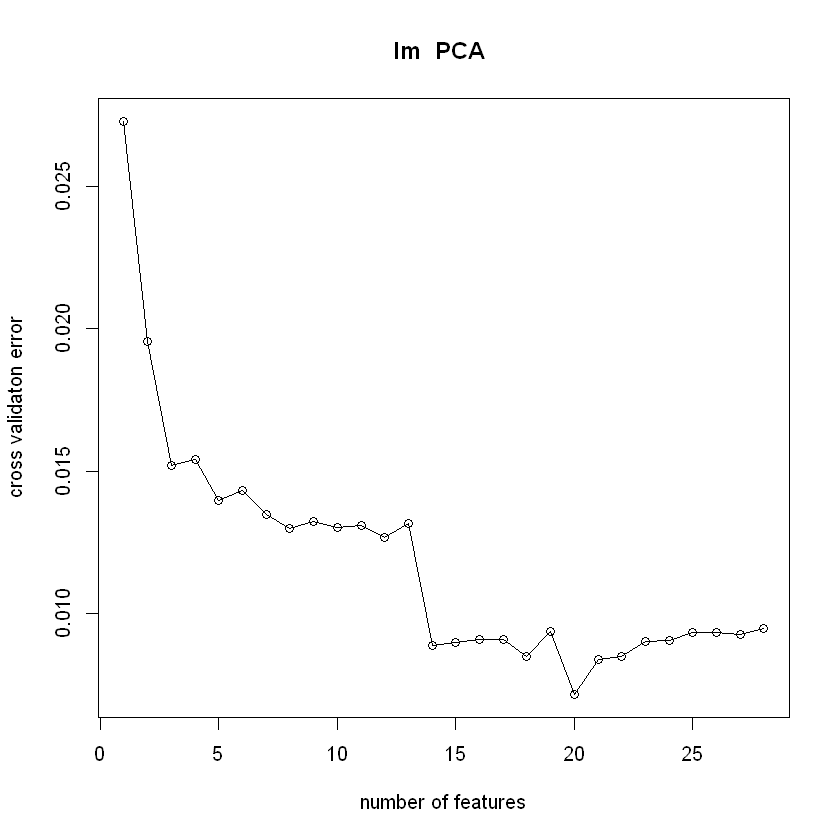

In [135]:
pca('lm', X, Y)

In [136]:
forwardSelection <- function(modelName, X, Y) {
  n <- ncol(X)
  size.CV<-floor(N/10)
  
  selected<-NULL
  
  for (round in 1:n) { 
    candidates<-setdiff(1:n,selected)
    
    CV.err<-matrix(0,nrow=length(candidates),ncol=10)
    
    for (j in 1:length(candidates)) {
      features_to_include<-c(selected,candidates[j])
      
      for (i in 1:10) {
        i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
        X.ts<-X[i.ts,features_to_include,drop=F]  
        Y.ts<-Y[i.ts]  
        
        i.tr<-setdiff(1:N,i.ts)
        X.tr<-X[i.tr,features_to_include,drop=F]
        Y.tr<-Y[i.tr]
        
        DS<-cbind(X.tr,SalePrice=Y.tr)
        
        if(modelName == 'lm') {
          model<- lm(SalePrice~.,DS)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'rpart') {
          model<- rpart(SalePrice~.,DS)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'tree') {
          model<- tree(SalePrice~.,DS)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'svm'){
          # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
          #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
          model<- svm(SalePrice~.,DS)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'nnet'){
          DS <- scale(DS)
          model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
          Y.hat.ts <- predict(model,X.ts)
        }
        if(modelName == 'lazy'){
          model<- lazy(SalePrice~.,DS)
          Y.hat.ts<- predict(model,X.ts)$h
        }
        
        CV.err[j,i]<-rmse(Y.hat.ts,Y.ts)
      }
    }
    CV.err.mean<-apply(CV.err,1,mean)
    CV.err.sd<-apply(CV.err,1,sd)
    selected_current<-which.min(CV.err.mean)              
    selected<-c(selected,candidates[selected_current])
    print(paste("Round ",round," ; Selected feature: ",candidates[selected_current]," ; CV error=",round(CV.err.mean[selected_current],digits=4), " ; std dev=",round(CV.err.sd[selected_current],digits=4)))
    
  }
  
  #print(paste('colnames(X)[selected] :', colnames(X)[selected]))
  #print(paste('colnames(X) ', colnames(X)))
}


In [78]:
forwardSelection('rpart', X, Y)

In [ ]:
forwardSelection('svm', X, Y)

In [ ]:
forwardSelection('lazy', X, Y)

In [ ]:
forwardSelection('tree', X, Y)

In [137]:
forwardSelection('lm', X, Y)

[1] "Round  1  ; Selected feature:  3  ; CV error= 0.0103  ; std dev= 0.0083"
[1] "Round  2  ; Selected feature:  9  ; CV error= 0.0085  ; std dev= 0.0071"
[1] "Round  3  ; Selected feature:  5  ; CV error= 0.0069  ; std dev= 0.0066"
[1] "Round  4  ; Selected feature:  20  ; CV error= 0.0061  ; std dev= 0.0056"
[1] "Round  5  ; Selected feature:  23  ; CV error= 0.0052  ; std dev= 0.0062"
[1] "Round  6  ; Selected feature:  25  ; CV error= 0.0051  ; std dev= 0.0066"
[1] "Round  7  ; Selected feature:  11  ; CV error= 0.005  ; std dev= 0.0072"
[1] "Round  8  ; Selected feature:  26  ; CV error= 0.0049  ; std dev= 0.0072"
[1] "Round  9  ; Selected feature:  27  ; CV error= 0.0049  ; std dev= 0.0072"
[1] "Round  10  ; Selected feature:  22  ; CV error= 0.0048  ; std dev= 0.0072"
[1] "Round  11  ; Selected feature:  24  ; CV error= 0.0048  ; std dev= 0.0062"
[1] "Round  12  ; Selected feature:  7  ; CV error= 0.0047  ; std dev= 0.0063"
[1] "Round  13  ; Selected feature:  14  ; CV error= 0

### Create cross validated models

:

Generic method which runs given model and calculates 10 fold cross validation:

In [138]:
runModel <- function(modelName, X, Y){

  size.CV<-floor(N/10)
  
  CV.err<-numeric(10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)  
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]                          
    
    DS<-cbind(X.tr,SalePrice=Y.tr)

    
    if(modelName == 'lm') {
      model<- lm(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'rpart') {
      model<- rpart(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'tree') {
      model<- tree(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'svm'){
      # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
      #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
      model<- svm(SalePrice~.,DS)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'nnet'){
      DS <- scale(DS)
      model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
      Y.hat.ts <- predict(model,X.ts)
    }
    if(modelName == 'lazy'){
      model<- lazy(SalePrice~.,DS)
      Y.hat.ts<- predict(model,X.ts)$h
    }
    
    CV.err[i]<-rmse(Y.hat.ts,Y.ts) 
  }
  print(paste(modelName, "  CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))
}

Ensemble model calculating 10 fold cross validation on 20 samples:

In [139]:

runEnsemble <- function(modelName, X, Y){
  
  R<-5
  size.CV<-floor(N/10)
  
  CV.err<-numeric(10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### Complete the code. i.ts should be the indices of the tessefor the i-th fold
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)                ### Complete the code. i.tr should be the indices of the training sefor the i-th fold
    Y.hat.ts.R<-matrix(0,nrow=nrow(X.ts),ncol=R)
    
    for (r in 1:R) {
      i.tr.resample<-sample(i.tr,rep=T)
      X.tr<-X[i.tr.resample,]
      Y.tr<-Y[i.tr.resample]       
      
      DS<-cbind(X.tr,SalePrice=Y.tr)
      
      if(modelName == 'lm') {
        model<- lm(SalePrice~.,DS)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'rpart') {
        model<- rpart(SalePrice~.,DS)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'tree') {
        model<- tree(SalePrice~.,DS)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'svm'){
        # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
        #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
        model<- svm(SalePrice~.,DS)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'nnet'){
        DS <- scale(DS)
        model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
        Y.hat.ts.R[,r] <- predict(model,X.ts)
      }
      if(modelName == 'lazy'){
        model<- lazy(SalePrice~.,DS)
        Y.hat.ts.R[,r]<- predict(model,X.ts)$h
      }
      
    }
    
    Y.hat.ts<-apply(Y.hat.ts.R,1,mean)
    CV.err[i]<-rmse(Y.hat.ts,Y.ts)
  }
  
  
  print(paste('Ensemble ', modelName, "  CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))
}


ensembleSimpleAverage <- function(models, X, Y){
  
  R<-5
  size.CV<-floor(N/10)
  
  CV.err<-numeric(10)
  
  for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### Complete the code. i.ts should be the indices of the tessefor the i-th fold
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
    
    i.tr<-setdiff(1:N,i.ts)                ### Complete the code. i.tr should be the indices of the training sefor the i-th fold
    Y.hat.ts.R<-matrix(0,nrow=nrow(X.ts),ncol= R * length(models))
    
    for( mi in 1: length(models)){
      modelName = models[mi]
      for (r in 1:R) {
        index <- (mi -1 ) * R + r

        i.tr.resample<-sample(i.tr,rep=T)
        X.tr<-X[i.tr.resample,]
        Y.tr<-Y[i.tr.resample]       
        
        DS<-cbind(X.tr,SalePrice=Y.tr)
        
        if(modelName == 'lm') {
          model<- lm(SalePrice~.,DS)
          Y.hat.ts.R[, r] <- predict(model,X.ts)
        }
        if(modelName == 'rpart') {
          model<- rpart(SalePrice~.,DS)
          Y.hat.ts.R[,index] <- predict(model,X.ts)
        }
        if(modelName == 'tree') {
          model<- tree(SalePrice~.,DS)
          Y.hat.ts.R[,r] <- predict(model,X.ts)
        }
        if(modelName == 'svm'){
          # model<- svm(SalePrice~.,DS, scale = T, center=T, kernel = 'radial', 
          #             shrinking = T, cross = 10, cost = 4, epislon = 0.2)
          model<- svm(SalePrice~.,DS)
          Y.hat.ts.R[,r] <- predict(model,X.ts)
        }
        if(modelName == 'nnet'){
          DS <- scale(DS)
          model<- nnet(SalePrice~.,DS, size =3, linout = TRUE, maxit=150, decay=0.3)
          Y.hat.ts.R[,r] <- predict(model,X.ts)
        }
        if(modelName == 'lazy'){
          model<- lazy(SalePrice~.,DS)
          Y.hat.ts.R[,r]<- predict(model,X.ts)$h
        }
      }
    }
    
    Y.hat.ts<-apply(Y.hat.ts.R,1,mean)
    CV.err[i]<-rmse(Y.hat.ts,Y.ts)
  }
  
  
  print(paste('Ensemble ', modelName, "  CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))
}




runModel('rpart', X, Y)
runEnsemble('rpart', X, Y)

runModel('lazy', X, Y)
runEnsemble('lazy', X, Y)


runModel('svm', X, Y)
runEnsemble('svm', X, Y)


runModel('knn', X, Y)
runEnsemble('knn', X, Y)

runModel('nnet', X, Y)
runEnsemble('nnet', X, Y)

In [67]:
runModel('rpart', X, Y)

[1] "rpart   CV error= 0.0142  ; std dev= 0.0109"


### Prediction

The following method writes to submission.csv the result outputed by given selection.

It recalculates original price as we transformed y = log(y_i + 1)

In [79]:
writePredictionToFile <- function (prediction) {
  predictedSalePrice <- exp(prediction) -1
  result <- cbind(Id = output$Id, SalePrice = predictedSalePrice )
  colnames(result) <- c("Id","SalePrice")
  write.csv(result, "submission.csv",row.names=FALSE)
}


In [80]:
model<- rpart(SalePrice~.,train)
prediction<- predict(model,test)

In [81]:
writePredictionToFile(prediction)